# COVID-19 Vaccine Dataset
Kaggle Links: [US Vaccine Tracker + Population Stats](https://www.kaggle.com/peretzcohen/us-vaccine-tracker/data#Your-turn_)

Using 2019 population data from the U.S. Census and COVID-19 vaccine records from Our World In Data on GitHub to visualize and forecast vaccine progression as it relates to total state population.
***

*import necessary modules*

In [85]:
import pandas as pd
import os
import requests
import json

import matplotlib.pyplot as plt
from datetime import datetime

plt.style.use('ggplot')

state_name = 'Georgia'

***
__Extract__<br>
Using 2019 Census data from kaggle and daily-updated covid-19 vaccination data from *Our World In Data*'s GitHub page 

In [86]:
cwd = os.getcwd()
pop_data = pd.read_csv(cwd + "\\data\\" + "2019_Census_US_Population_Data_By_State_Lat_Long.csv")
vacc_data = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/us_state_vaccinations.csv")

In [87]:
# pull unemployment data from BLS.gov website
# series_id codes -- LA (Local Area unemployment) 
#                    S/U (seasonally adjusted/not adjusted) 
#                    ST (area code - 'state') 
#                    ## (state code) 
#                    00000000000 (area code)
#                    03/04 (measure code - 03 = unemployment rate, 04 = unemployment)
#                    ex. LASST240000000000004 = local area unemployment by state, seasonally adjusted, Marlyand unemployment data

# creating state-to-seriesid reference map
state_map = pd.read_csv(cwd + "\\data\\sm_state.csv")
series_codes = {}
for i in range(len(state_map.state_name)):
    state = state_map.state_name.iloc[i]
    code = f"{state_map.state_code.iloc[i]:02}"
    series_id = f"LASST{code}0000000000003"
    series_codes[state] = series_id

def load_series(series_code, start_year, end_year):
    headers = {'Content-type': 'application/json'}
    data = json.dumps({"seriesid": [series_code], "startyear": start_year, "endyear": end_year})
    p = requests.post('https://api.bls.gov/publicAPI/v1/timeseries/data/', data = data, headers = headers)
    json_data = p.json()
    return json_data
        

json_data = load_series(series_codes[state_name], "2019", "2021")

In [88]:
response_data = json_data['Results']['series'][0]['data']

dates = []
values = []
for n in response_data:
    dates.append(datetime.strptime(f"{n['year']}-{n['periodName']}", '%Y-%B'))
    values.append(float(n['value']))
    
df = pd.DataFrame({'date': dates, 'value': values})
df.date = pd.to_datetime(df.date)
df = df.sort_values(by='date')
#df.plot(x='date', y='value', label='unemployed', color='orange')

***
__Transform__

Combine population by state and total vaccinations by state

In [89]:
vacc_data.dropna(subset=['people_vaccinated'], inplace=True)
pop_data.dropna(subset=['POPESTIMATE2019'], inplace=True)

pop_data.rename(columns={'STATE': 'location', 'POPESTIMATE2019': 'population'}, inplace=True)

vacc_data_state = vacc_data[['date', 'location', 'people_vaccinated']]
pop_data_state = pop_data[['location', 'population']]

merged = pd.merge(vacc_data_state, pop_data_state, how='inner', on=['location'])
merged.dropna(subset=['population'], inplace=True)

merged.location = merged.location.astype(str)
merged['percent'] = merged.people_vaccinated / merged.population * 100

merged.columns = merged.columns.str.strip()
merged.date = pd.to_datetime(merged.date, format='%Y-%m-%d')

***
__Visualizations__<br>
Modify <code>state_name</code> on line 16 to determine which state's vaccine records you would like to further understand. All following cells use this specified state as reference. Use <code>plot_state(state_name, vis)</code> or <code>plot_all()</code> on line 17 to plot data from a single state, or all data combined.

In [90]:
total_vacc = sum(merged.people_vaccinated)
us_pop = sum(merged.groupby('location').population.max().reset_index().population)
perc = "{:.2f}".format(total_vacc/us_pop)
print(f"Total % vaccinated in the US: {perc}%")

Total % vaccinated in the US: 70.63%


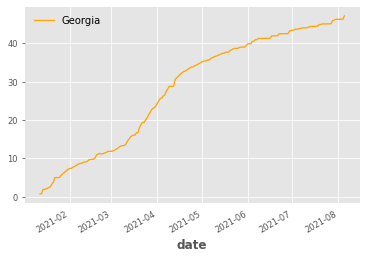

In [91]:
vis = merged[['date', 'percent', 'location']]

def plot_state(state_name, vis, label, color):
    # limiting vis data to a single state
    vis = vis.loc[vis['location'] == state_name]
    vis = vis[['date', 'percent']]
    vis.plot(kind='line', x='date', y='percent', label=label, color=color)

def plot_all(vis):
    groups = vis.groupby('location')
    for name, group in groups:
        plt.plot(group['date'], group['percent'], label=name)

plot_state(state_name, vis, state_name, 'orange')
#plot_all(vis)

***
__Model Testing__

In [92]:
state = merged.loc[merged['location'] == state_name]
state = state[['date', 'location', 'percent']]

In [93]:
from darts import TimeSeries
import darts.models as models
from darts.metrics import mape, mase
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis

get_data = pd.DataFrame({'date': state.date, 'percent': state.percent})

# fill missing dates with padded vaccination percent data. 0.0 values would otherwise disrupt the model
reset = pd.date_range(start=get_data.date.min(), end=get_data.date.max())
get_data = get_data.set_index('date').reindex(reset).fillna(method='pad').rename_axis('date').reset_index()

series = TimeSeries.from_dataframe(get_data, 'date', 'percent')
# split train/test down the middle of the dataset [get_data.date.median()]
train, test = series.split_before(pd.Timestamp('2021-06-25'))

def test_models(models, train, test):
    best = None
    lowest = float('inf')
    for model in models:
        model.fit(train)
        forecast = model.predict(len(test))
        err = mape(test, forecast)
        if err < lowest:
            lowest = err
            best = model
    print('Best model ({}) obtains MAPE: {:.2f}%'.format(best, lowest))
    return best

models = [models.ARIMA(), models.ExponentialSmoothing(), models.Theta(), models.AutoARIMA()]
best_model = test_models(models, train, test)

C:\Users\ramis\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
[2021-08-06 12:13:58,563] INFO | darts.utils.statistics | The ACF has no local maximum for m < max_lag = 82.
[2021-08-06 12:13:58,564] INFO | darts.models.theta | Theta model inferred seasonality of training series: 0
[2021-08-06 12:13:58,564] INFO | darts.models.theta | Theta model inferred seasonality of training series: 0


Best model (ARIMA(12, 1, 0)) obtains MAPE: 0.54%


***
__Forecasting and Visualizing__

<ipython-input-94-18ee38e3d25b>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:0.0f}%'.format(x) for x in plt.gca().get_yticks()])


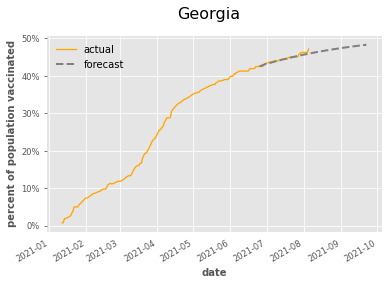

In [94]:
#predict next X days of vaccinations
pred = best_model.predict(90)

plot_state(state_name, vis, 'actual', 'orange')
pred.plot(label='forecast', lw=2, linestyle='dashed', color='gray')

plt.suptitle(state.location.iloc[0], fontsize='16')
plt.ylabel('percent of population vaccinated', fontsize='10')
plt.gca().set_yticklabels(['{:0.0f}%'.format(x) for x in plt.gca().get_yticks()]) 
plt.xlabel('date', fontsize='10')
plt.legend()

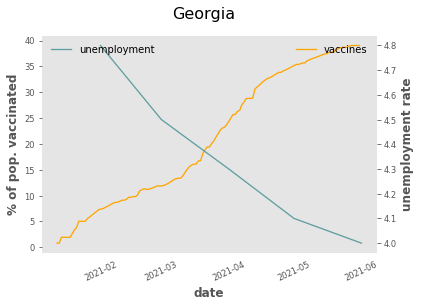

In [95]:
# plot covid-19 vaccine data
fig, ax = plt.subplots()
plt.xticks(rotation=25)
plt.xlabel('date')

get_data = get_data.loc[get_data.date < df.date.max()]
ax.plot(get_data.date, get_data.percent, color='orange', label='vaccines')
#pred.plot(label='forecast', lw=2, linestyle='dashed', color='gray')

df = df.loc[df.date > get_data.date.min()]

ax2 = ax.twinx()
ax2.plot(df.date, df.value, color='cadetblue', label='unemployment')

ax.grid(False)
ax2.grid(False)
ax.legend(loc='upper right')
ax2.legend(loc='upper left')

plt.suptitle(state_name, fontsize='16')
ax.set_ylabel('% of pop. vaccinated')
ax2.set_ylabel('unemployment rate')
plt.show()